# Spatial data analysis

We have experimental live cell microscopy data from an experiment that monitored the activity of two important signalling pathways:
ERK and AKT. For this purpose, a cell line was transfected with fluorescent biosensors:

*   H2B-miRFP703 (nuclear tracer),
*   ErkKTR-mTurq.2 (to measure the activity of the RK pathway),
*   FoxO-mNeonGreen (to measure the activity of the AKT pathway)

The experiment was carried out under the following conditions:


1.   Cells were deprived of growth factors for 48 hours prior to imaging
2.   Cells were cultured in 96-well plates coated with fibronectin (0.25 μg/cm^$2$)
3.   Images were acquired every 5 minutes for 24 hours

Each cell (marked with a unique track_id) has a time series of observations covering:
* ERK and AKT activity changes (ERKKTR_ratio, FoxO3A_ratio),
* nucleus size (Nuclear_size),
* spatial location (objNuclei_Location_Centre_X/Y),
* time of observation (Image_Metadata_T)

In addition, each observation is derived from a specific experiment (Exp_ID) and location on the plate (Image_Metadata_Site). We treat the Image_Metadata_Site values as indicators of experimental repetition. The dataset contains observations for cell lines k with different mutations.

Import of necessary libraries and files.

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
from typing import List
from sklearn.neighbors import KDTree
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [2]:
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz?raw=true -O single-cell-tracks.csv.gz

data = pd.read_csv("/content/single-cell-tracks.csv.gz")

--2025-04-13 20:34:43--  https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz [following]
--2025-04-13 20:34:43--  https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/single-cell-tracks_exp1-6_noErbB2.csv.gz [following]
--2025-04-13 20:34:43--  https://media.githubusercontent.com/media/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/single-cell-tracks_exp1

# Initial data exploration

In [13]:
data.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Time_min,Mutation
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248,0,WT
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174,5,WT
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787,10,WT
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453,15,WT
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885,20,WT


In [14]:
data.describe()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,Time_min
count,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07
mean,3.593846e+00,9.654818e+00,7.631083e+02,1.283255e+02,3.560427e+02,9.047551e-01,1.291381e+00,5.129958e+02,5.097858e+02,6.416274e+02
std,1.766744e+00,5.682569e+00,6.784322e+02,7.446081e+01,1.289045e+02,2.278312e-01,2.036630e-01,2.970606e+02,2.972352e+02,3.723040e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,2.078950e+00,2.119400e+00,0.000000e+00
25%,2.000000e+00,5.000000e+00,2.870000e+02,6.400000e+01,2.789990e+02,7.534900e-01,1.169790e+00,2.558600e+02,2.520280e+02,3.200000e+02
50%,4.000000e+00,9.000000e+00,5.940000e+02,1.280000e+02,3.330000e+02,8.670850e-01,1.292390e+00,5.147730e+02,5.084320e+02,6.400000e+02
75%,5.000000e+00,1.400000e+01,1.024000e+03,1.930000e+02,4.069990e+02,1.025020e+00,1.415030e+00,7.711060e+02,7.672950e+02,9.650000e+02
max,6.000000e+00,2.400000e+01,6.345000e+03,2.570000e+02,2.308000e+03,6.196320e+00,5.403080e+00,1.020310e+03,1.020930e+03,1.285000e+03


In [27]:
# Number of experiments in data
experiments = data["Exp_ID"].unique()
print(f"Znaleziono {len(experiments)} eksperymentów: {experiments}")

Znaleziono 6 eksperymentów: [1 2 3 4 5 6]


In [3]:
# Duration of the experiment
data['Time_min'] = data['Image_Metadata_T'] * 5
max_frame = data['Time_min'].max()
print(f"Długość eksperymentu: {max_frame}min ({max_frame / 60:.2f} godzin)")

Długość eksperymentu: 1285min (21.42 godzin)


In [53]:
def plot_cells_per_time_per_exp(df: pd.DataFrame, experiments: List[int]) -> None:
    for exp in experiments:
        df_exp = df[df['Exp_ID'] == exp]
        grouped = df_exp.groupby(['Time_min', 'Image_Metadata_Site'])['track_id'].nunique().reset_index()
        grouped = grouped.rename(columns={'track_id': 'cell_count'})

        # Take mean from Image_Metadata_Site
        avg_cells_per_time = grouped.groupby('Time_min')['cell_count'].mean().reset_index()

        fig_hist = px.bar(avg_cells_per_time, x='Time_min', y='cell_count',
                          labels={'Time_min': 'Czas [min]', 'cell_count': 'Średnia liczba komórek'},
                          title=f"Średnia liczba komórek w czasie – Eksperyment {exp}")
        fig_hist.update_layout(bargap=0.2)
        fig_hist.show()

plot_cells_per_time_per_exp(data, experiments)

In [45]:
def plot_cell_trajectory(df: pd.DataFrame,
                         track_id: int = 1,
                         exp_id: int = 1,
                         site_id: int = 1,
                         show_location: bool = True
                         ) -> None:
    df_cell = df[
              (df['track_id'] == track_id) &
              (df['Exp_ID'] == exp_id) &
              (df['Image_Metadata_Site'] == site_id)
    ]

    if df_cell.empty:
        print(f"Brak danych dla track_id = {track_id}")
        return None

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_cell['Time_min'], y=df_cell['ERKKTR_ratio'],
                             mode='lines+markers', name='ERK', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df_cell['Time_min'], y=df_cell['FoxO3A_ratio'],
                             mode='lines+markers', name='AKT', line=dict(color='red')))

    fig.update_layout(title=f"Trajektoria komórki o trace_id = {track_id} (eksperyment {exp_id}, powtórzenie {site_id})",
                      xaxis_title="Czas [min]", yaxis_title="Poziom sygnału",
                      legend=dict(x=0.02, y=0.98), height=500)
    fig.show()

    if show_location:
        fig_loc = px.scatter(df_cell, x='objNuclei_Location_Center_X', y='objNuclei_Location_Center_Y',
                             title=f"Lokalizacja komórki {track_id} (eksperyment {exp_id}, powtórzenie {site_id})",
                             labels={'objNuclei_Location_Center_X': 'X', 'objNuclei_Location_Center_Y': 'Y'},
                             color='Time_min',)
        fig_loc.update_traces(marker=dict(size=10))
        fig_loc.update_layout(height=500)
        fig_loc.show()

    # Time gaps for 10 minutes interval
    time_gaps = df_cell['Time_min'].diff()
    if (time_gaps > 10).any():
        print(f"Komórka o  track_id={track_id} ma przerwy w czasie w eksperymencie {exp_id}:")
        print(time_gaps[time_gaps > 10])

plot_cell_trajectory(data)

In [46]:
# Example of signal level for different experiments
for exp in experiments:
  plot_cell_trajectory(data, exp_id=exp, show_location=False)

In [60]:
# Frequency histogram of the number of cells in the field of view
def plot_histogram_cell_counts_per_image(df: pd.DataFrame) -> None:
    grouped = df.groupby(['Exp_ID', 'Image_Metadata_Site', 'Image_Metadata_T'])['track_id'].nunique().reset_index()
    grouped = grouped.rename(columns={'track_id': 'cell_count'})

    # Histogram
    fig = px.histogram(grouped, x='cell_count', color='Exp_ID', barmode='overlay',
                       labels={'cell_count': 'Liczba komórek', 'Exp_ID': 'Eksperyment'},
                       title="Histogram liczby komórek na jednym obrazku (dla wszystkich eksperymentów)",
                       nbins=100)
    fig.update_layout(bargap=0.1)
    fig.show()

plot_histogram_cell_counts_per_image(data)

It is worth noting that there is a fair amount of variation within a single experiment in the repetition of the experiment (*Image_Metadata_Site*). In addition, only experiment 6 was repeated the maximum number of times 24, the other experiments were repeated less.

In [71]:
# Analysis for different sites of the experiments
for i in range(1, 25, 4):
  print(f"Site = {i}")
  plot_histogram_cell_counts_per_image(data[data["Image_Metadata_Site"] == i])

Site = 1


Site = 5


Site = 9


Site = 13


Site = 17


Site = 21


# Comparison of signalling pathway activity between mutants

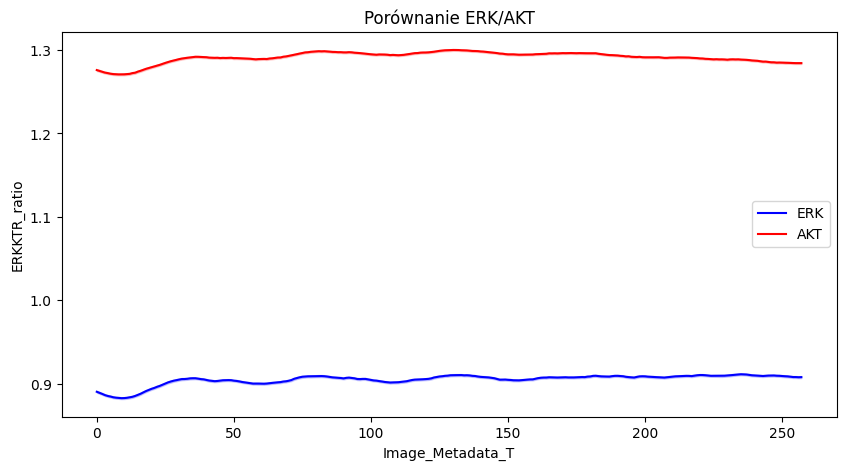

In [65]:
# ERK/AKT activity trajectories for whole data
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x='Image_Metadata_T', y='ERKKTR_ratio', label='ERK', color='blue')
sns.lineplot(data=data, x='Image_Metadata_T', y='FoxO3A_ratio', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()

From the metadata, we know that different cell lines with the following mutations were used depending on the Image_Metadata_Site:


*   WT (1-4)
*   AKT1-E17K (5-8)
*   PIK3CA-E545K (9 - 12)
*   PIK3CA-H1047R (13 - 16)
*   PTEN (17 - 24)

All mutations except the wild-type (WT) strain increase AKT pathway activity.



In [4]:
sites = [
    (data['Image_Metadata_Site'] >= 1) & (data['Image_Metadata_Site'] <= 4),
    (data['Image_Metadata_Site'] >= 5) & (data['Image_Metadata_Site'] <= 8),
    (data['Image_Metadata_Site'] >= 9) & (data['Image_Metadata_Site'] <= 12),
    (data['Image_Metadata_Site'] >= 13) & (data['Image_Metadata_Site'] <= 16),
    (data['Image_Metadata_Site'] >= 17),
]

mutations = ['WT', 'AKT1_E17K', 'PIK3CA_E545K', 'PIK3CA_H1047R', 'PTEN_del']

data['Mutation'] = np.select(sites, mutations, default='Unknown')

In [56]:
def plot_mean_signal_with_uncertainty(df: pd.DataFrame,
                                      signal_col: str,
                                      label: str,
                                      mutation_col: str = 'Mutation',
                                      method: str = 'std',  # 'std' lub 'percentile'
                                      lower_percentile: float = 5,
                                      upper_percentile: float = 95) -> None:
    """ The function draws a plot of the average signal activity
    with a selected "uncertainty".

    Parameters:
      - df: DataFrame with data, containing columns: Time_min, mutation_col.
      - signal_col: name of signal column (e.g. 'ERKKTR_ratio').
      - label: signal label (used in axis titles of plot).
      - mutation_col: column specifying the mutation (default: Mutation).
      - method: choice of the way to visualise the uncertainty:
          'std' -> area = mean +/- standard deviation,
          'percentile' → area = percentile interval.
      - lower_percentile, upper_percentile: percentiles used
                                            with method 'percentile'.
    """
    # Colors
    colors = plotly.colors.qualitative.Plotly

    if method == 'std':
        grouped = df.groupby(['Time_min', mutation_col])[signal_col].agg(['mean', 'std']).reset_index()
    elif method == 'percentile':
        grouped = df.groupby(['Time_min', mutation_col])[signal_col].agg(
            mean='mean',
            lower=lambda x: np.percentile(x, lower_percentile),
            upper=lambda x: np.percentile(x, upper_percentile)
        ).reset_index()
    else:
        raise ValueError("Unknown method: Use 'std' or 'percentile'.")

    fig = go.Figure()
    mutations = grouped[mutation_col].unique()
    color_map = {mut: colors[i % len(colors)] for i, mut in enumerate(mutations)}

    for mut in mutations:
        g = grouped[grouped[mutation_col] == mut]
        line_color = color_map[mut]

        # Colour convertion to RGB
        rgb = plotly.colors.hex_to_rgb(line_color)
        fill_color = f'rgba{rgb + (0.2,)}'

        # MEAN
        fig.add_trace(go.Scatter(
            x=g['Time_min'],
            y=g['mean'],
            mode='lines',
            name=f"{mut}",
            line=dict(color=line_color, width=2),
            legendgroup=mut
        ))

        # Uncertainty Area
        if method == 'std':
            uncertainty_lower = g['mean'] - g['std']
            uncertainty_upper = g['mean'] + g['std']
        else:
            uncertainty_lower = g['lower']
            uncertainty_upper = g['upper']

        fig.add_trace(go.Scatter(
            x=np.concatenate([g['Time_min'], g['Time_min'][::-1]]),
            y=np.concatenate([uncertainty_upper, uncertainty_lower[::-1]]),
            fill='toself',
            fillcolor=fill_color,
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
            legendgroup=mut
        ))

    fig.update_layout(
        title=f"Średnia aktywność sygnału {label} z obszarem niepewności ({method})",
        xaxis_title="Czas [min]",
        yaxis_title=f"Poziom {label}",
        height=500
    )

    fig.show()


plot_mean_signal_with_uncertainty(data, 'ERKKTR_ratio', 'ERK')
plot_mean_signal_with_uncertainty(data, 'FoxO3A_ratio', 'AKT')

In [60]:
def statistical_test_vs_wt(df: pd.DataFrame,
                          signal_col: str,
                          time_range: tuple = (60, 180),  # Poprawiony domyślny zakres czasowy
                          mutation_col: str = 'Mutation',  # Dostosowane do polskiej kolumny
                          wt_label: str = 'WT') -> pd.DataFrame:
    """
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame zawierający dane
    signal_col : str
        Nazwa kolumny z sygnałem do analizy (np. 'ERKKTR_ratio' lub 'Fox03A_ratio')
    time_range : tuple
        Zakres czasowy w minutach (domyślnie 60-180 minut)
    mutation_col : str
        Nazwa kolumny z typem mutacji (domyślnie 'mutacja')
    wt_label : str
        Etykieta dla typu dzikiego (domyślnie 'WT')

    Returns:
    --------
    pd.DataFrame
        Tabela z wynikami testów statystycznych
    """

    # Filtracja czasu
    df_sel = df[(df['Image_Metadata_T'] >= time_range[0]) &
               (df['Image_Metadata_T'] <= time_range[1])]

    # Obliczanie średniej aktywności
    df_avg = df_sel.groupby(['track_id', mutation_col])[signal_col].mean().reset_index()

    results = []
    wt_values = df_avg[df_avg[mutation_col] == wt_label][signal_col]

    # Testy dla każdej mutacji
    for mut in df_avg[mutation_col].unique():
        if mut == wt_label:
            continue

        mut_values = df_avg[df_avg[mutation_col] == mut][signal_col]
        stat, p = mannwhitneyu(wt_values, mut_values, alternative='two-sided')
        results.append({
            'Mutacja': mut,
            'Statystyka': stat,
            'p_wartość': p,
            'Sygnał': signal_col  # Dodano identyfikator sygnału
        })

    # Korekta Bonferroniego
    pvals = [r['p_wartość'] for r in results]
    _, pvals_corr, _, _ = multipletests(pvals, method='bonferroni')

    for r, p_corr in zip(results, pvals_corr):
        r['p_skorygowana'] = p_corr

    return pd.DataFrame(results).sort_values('p_skorygowana')

df_erk = statistical_test_vs_wt(data, 'FoxO3A_ratio')
df_akt = statistical_test_vs_wt(data, 'ERKKTR_ratio')

In [64]:
df_erk.head()

,Mutacja,Statystyka,p_wartość,Sygnał,p_skorygowana
0,AKT1_E17K,2704296.0,2.439027e-124,FoxO3A_ratio,9.756109e-124
1,PIK3CA_E545K,8250860.0,7.608408e-106,FoxO3A_ratio,3.043363e-105
3,PTEN_del,3419326.0,2.772225e-15,FoxO3A_ratio,1.108890e-14
2,PIK3CA_H1047R,4088894.0,1.925506e-01,FoxO3A_ratio,7.702023e-01


In [63]:
df_akt.head()

,Mutacja,Statystyka,p_wartość,Sygnał,p_skorygowana
2,PIK3CA_H1047R,816577.0,0.000000e+00,ERKKTR_ratio,0.000000e+00
3,PTEN_del,1382116.0,3.564764e-237,ERKKTR_ratio,1.425906e-236
1,PIK3CA_E545K,3761304.0,1.979419e-186,ERKKTR_ratio,7.917674e-186
0,AKT1_E17K,4104776.0,6.589212e-02,ERKKTR_ratio,2.635685e-01


# Analysis of spatial coordination and signal dynamics

# Sanity Check

In [22]:
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/WT.csv.gz?raw=true -O wt.csv.gz
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/AKT1-E17K.csv.gz?raw=true -O akt.csv.gz
!wget https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/PIK3CA-E545K.csv.gz?raw=true -O pik.csv.gz

data_wt = pd.read_csv("/content/wt.csv.gz")
data_akt = pd.read_csv("/content/akt.csv.gz")
data_pik = pd.read_csv("/content/pik.csv.gz")

--2025-04-13 21:29:13--  https://github.com/kugi8412/Spatiotemporal-Signaling/blob/main/data/WT.csv.gz?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/WT.csv.gz [following]
--2025-04-13 21:29:13--  https://github.com/kugi8412/Spatiotemporal-Signaling/raw/refs/heads/main/data/WT.csv.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/WT.csv.gz [following]
--2025-04-13 21:29:14--  https://raw.githubusercontent.com/kugi8412/Spatiotemporal-Signaling/refs/heads/main/data/WT.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercon

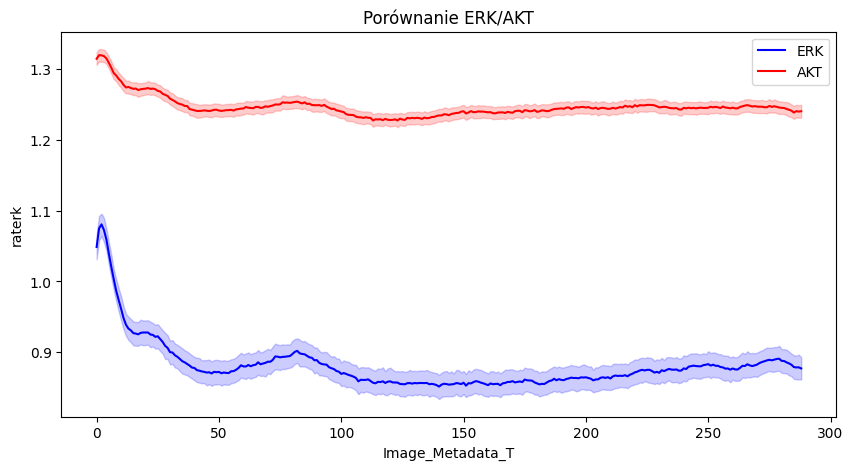

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data_wt, x='Image_Metadata_T', y='raterk', label='ERK', color='blue')
sns.lineplot(data=data_wt, x='Image_Metadata_T', y='ratakt', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()

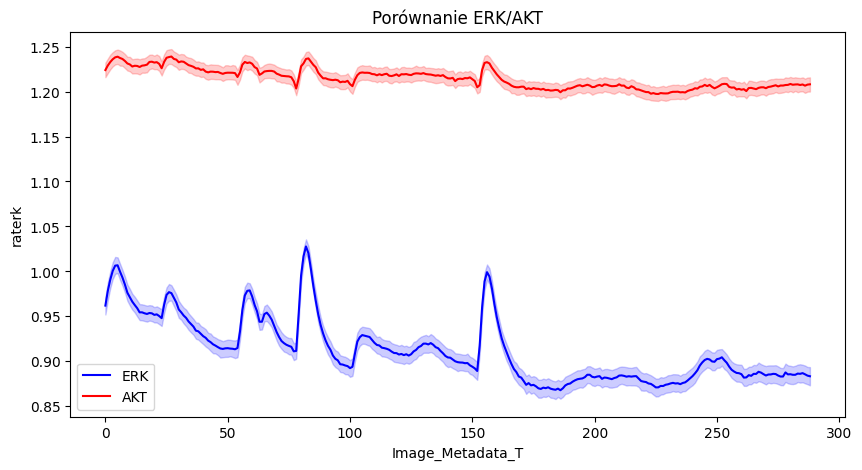

In [24]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data_pik, x='Image_Metadata_T', y='raterk', label='ERK', color='blue')
sns.lineplot(data=data_pik, x='Image_Metadata_T', y='ratakt', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()

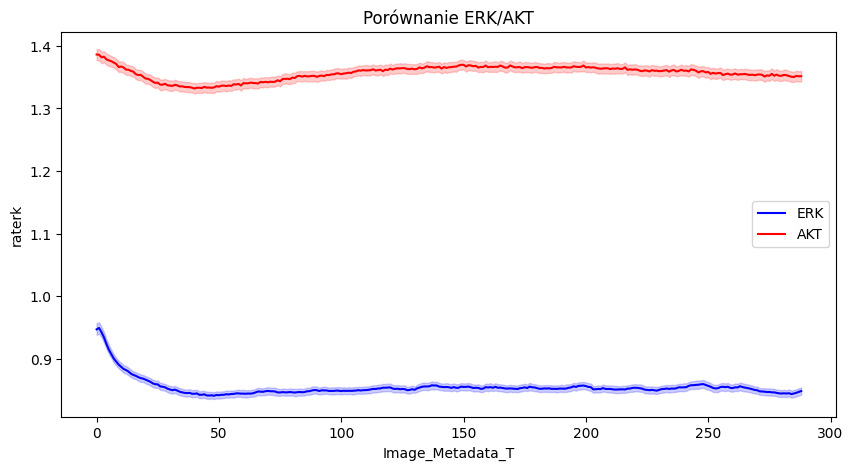

In [25]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data_akt, x='Image_Metadata_T', y='raterk', label='ERK', color='blue')
sns.lineplot(data=data_akt, x='Image_Metadata_T', y='ratakt', label='AKT', color='red')
plt.title("Porównanie ERK/AKT")
plt.legend()
plt.show()